#  Deep Learning Project 2 - GANs

## Instructions on How to Run
1. **Dataset**: Download the Anime Face Dataset (~63K images) and unzip into `./animefacedataset/images/`.  
2. **Environment**: Ensure you have
   - Python 3.9+
   - PyTorch & TorchVision
   - Matplotlib, tqdm
3. **Launch**: Open this Jupyter Notebook and run each cell from top to bottom.  
4. **GPU**: If available, the code will automatically use CUDA.  
5. **Outputs**: Generated samples will be saved in `generated/`.  

# Introduction

Generative Adversarial Networks (GANs) are a class of unsupervised generative models composed of two neural networks:

- **Generator**: learns to map random noise to realistic images.  
- **Discriminator**: learns to distinguish real images from generator’s fakes.  

Training is a minimax game:

$$
\min_{G} \max_{D}\; 
\mathbb{E}_{x\sim p_{\text{data}}}\bigl[\log D(x)\bigr]\;+\;\mathbb{E}_{z\sim p_{z}}\bigl[\log\bigl(1 - D(G(z))\bigr)\bigr]
$$

Here we train a DCGAN to generate **64×64** anime faces.


## Importing the Necessary Libraries and the Dataset

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torch.nn.functional as F
from tqdm.notebook import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset & Data Loader
We load and normalize 63,000+ cropped anime faces to \[-1,1\] range:
- Resize & center-crop to 64×64
- Normalize channels to mean=0.5, std=0.5

In [2]:
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [3]:
print(os.listdir(DATA_DIR+'/images')[:10])

['14020_2006.jpg', '13333_2005.jpg', '60934_2018.jpg', '49439_2015.jpg', '45935_2014.jpg', '48835_2014.jpg', '24253_2008.jpg', '54760_2016.jpg', '7697_2004.jpg', '54228_2016.jpg']


In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)
  
#image = ((image * std) + mean) --> transform image back in [0 1] range
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

## Visualizing a Batch of Real Images
Helper functions to denormalize and display samples from the dataset.

In [5]:
def show_images(images, nmax=64):

    grid = make_grid(denorm(images[:nmax]), nrow=8)

    np_grid = grid.detach().cpu().permute(1, 2, 0).numpy()

    plt.clf()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(np_grid)
    plt.show()

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

<Figure size 640x480 with 0 Axes>

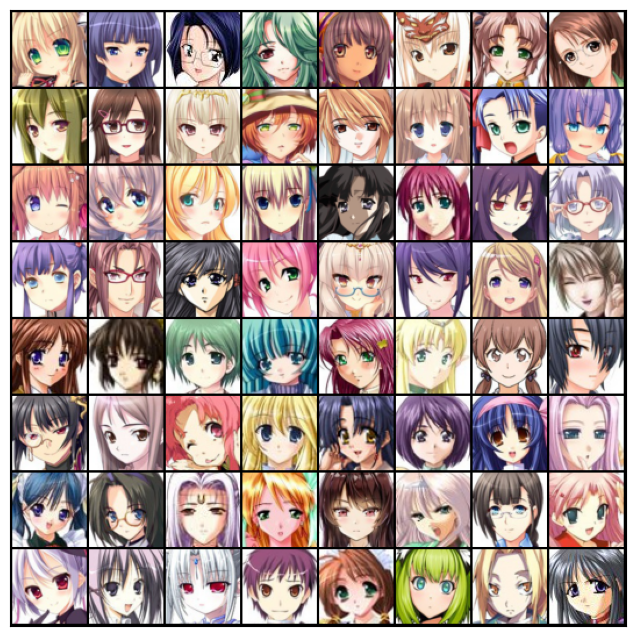

In [6]:
show_batch(train_dl)

# Using a GPU

Move data and models to GPU if available:
- `get_default_device()` picks CPU/GPU.
- `DeviceDataLoader` wraps the DataLoader.

In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

The discriminator is a CNN that outputs a probability (real vs fake):
- 4×4 convolutions with stride=2
- BatchNorm + LeakyReLU
- Final 4×4 conv → Flatten → Sigmoid

In [10]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    # in: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    # in: 128 x 16 x 16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    # in: 256 x 8 x 8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    #Add only conv2d layer here to output 1x1x1 value
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Let's move the discriminator model to the chosen device.

In [11]:
discriminator = to_device(discriminator, device)

# Generator Network

The generator uses ConvTranspose2d to upsample from a **128-dim** latent vector:
- 4×4 transpose convolutions
- BatchNorm + ReLU (except output)
- Final Tanh to match normalized image range

In [12]:
latent_size = 128

In [13]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


<Figure size 640x480 with 0 Axes>

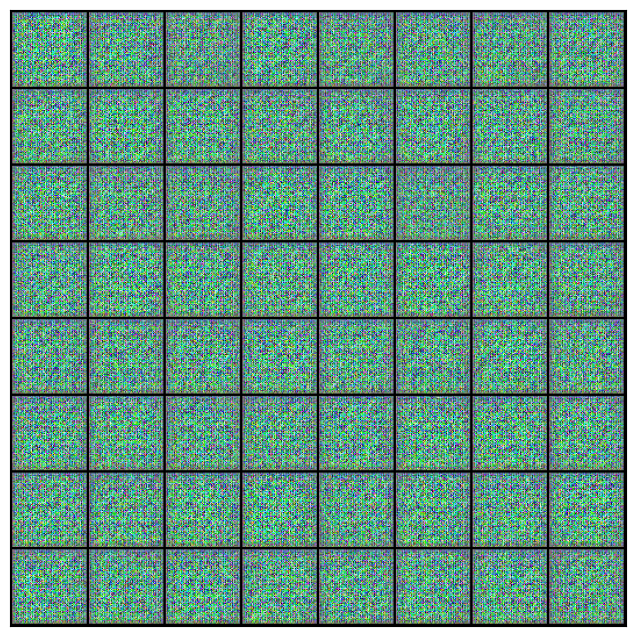

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Let's move the generator to the chosen device.

In [15]:
generator = to_device(generator, device)

# Discriminator Training

For each real batch:
1. Compute BCE loss against 1’s  
2. Generate fake images, compute BCE loss against 0’s  
3. Backprop & update *only* discriminator’s weights

In [16]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent).detach()  # So that only discriminators weight get updated

    # Pass fake images through discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

# Generator Training

1. Generate fake images  
2. Pass them to the discriminator  
3. Compute BCE loss against 1’s (generator “wants” them to look real)  
4. Backprop & update *only* generator’s weights

In [17]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

## Saving Generated Samples
Use a fixed latent tensor to track progression over epochs:
- Saves **8×8 grid** images as `generated-images-XXXX.png`

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
    print('Saving', fake_fname)
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999529..0.9999185].


Saving generated-images-0000.png


# Full Training Loop

Alternately train discriminator & generator across **N epochs**:
- Record and print losses & real/fake scores  
- Save sample images every epoch

In [21]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        epoch_d_loss = 0.0
        epoch_g_loss = 0.0
        epoch_real_score = 0.0
        epoch_fake_score = 0.0
        n_batches = 0
        
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # Train generator
            loss_g = train_generator(opt_g)

            epoch_d_loss += loss_d
            epoch_g_loss += loss_g
            epoch_real_score += real_score
            epoch_fake_score += fake_score
            n_batches += 1
            
            
        # Record losses & scores
        losses_g.append(epoch_g_loss / n_batches)
        losses_d.append(epoch_d_loss / n_batches)
        real_scores.append(epoch_real_score / n_batches)
        fake_scores.append(epoch_fake_score / n_batches)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

history = fit(epochs, lr)

losses_g, losses_d, real_scores, fake_scores = history

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.2329, loss_d: 0.6921, real_score: 0.6644, fake_score: 0.1859
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 6.8812, loss_d: 2.5500, real_score: 0.1319, fake_score: 0.0007
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.0713, loss_d: 0.3016, real_score: 0.8420, fake_score: 0.0952
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.0258, loss_d: 0.4714, real_score: 0.8621, fake_score: 0.2343
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.4628, loss_d: 0.1068, real_score: 0.9454, fake_score: 0.0360
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

## Checkpointing
After training, save model weights:
```python
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [ ]:
Image('./generated/generated-images-0001.png')

In [ ]:
Image('./generated/generated-images-0005.png')

In [ ]:
Image('./generated/generated-images-0010.png')

In [ ]:
Image('./generated/generated-images-0020.png')

In [ ]:
Image('./generated/generated-images-0025.png')

# Plotting Loss of Generator & Discriminator

In [ ]:
epochs_range = list(range(1, len(losses_d) + 1))

In [ ]:
plt.clf()
plt.plot(epochs_range, losses_d, label="Discriminator")
plt.plot(epochs_range, losses_g, label="Generator")
plt.xlabel("Epoch")
plt.ylabel("Losses")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Real & Fake Scores

In [ ]:
plt.clf()
plt.plot(epochs_range, real_scores, label="Real Score")
plt.plot(epochs_range, fake_scores, label="Fake Score")
plt.xlabel("Epoch")
plt.ylabel("Scores")
plt.title("Real vs Fake Scores per Epoch")
plt.legend()
plt.grid(True)
plt.show()